In [1]:
pip install statsmodels --upgrade

In [2]:
import warnings

import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import statsmodels as sm
import tensorflow as tf
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller






from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm

In [3]:
from urllib.request import urlretrieve
urlretrieve("https://raw.githubusercontent.com/jiwidi/time-series-forecasting-with-python/master/datasets/air_pollution.csv", "air_pollution.csv")

('air_pollution.csv', <http.client.HTTPMessage at 0x7faf7269d890>)

In [4]:
air_pollution = pd.read_csv('air_pollution.csv', parse_dates=['date'])
air_pollution.set_index('date', inplace=True)
air_pollution.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2010-01-02 to 2014-12-31
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pollution_today      1825 non-null   float64
 1   dew                  1825 non-null   float64
 2   temp                 1825 non-null   float64
 3   press                1825 non-null   float64
 4   wnd_spd              1825 non-null   float64
 5   snow                 1825 non-null   float64
 6   rain                 1825 non-null   float64
 7   pollution_yesterday  1825 non-null   float64
dtypes: float64(8)
memory usage: 128.3 KB


In [5]:
air_pollution


,pollution_today,dew,temp,press,wnd_spd,snow,rain,pollution_yesterday
date,,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0,10.041667
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0,145.958333
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0,78.833333
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0,31.333333
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0,42.458333
...,...,...,...,...,...,...,...,...
2014-12-27,238.666667,-9.666667,-1.791667,1027.833333,9.278333,0.000000,0.0,170.250000
2014-12-28,197.375000,-10.791667,1.583333,1019.958333,10.948750,0.000000,0.0,238.666667
2014-12-29,159.000000,-12.333333,0.750000,1013.750000,8.000000,0.000000,0.0,197.375000


In [6]:
air_pollution.describe()

,pollution_today,dew,temp,press,wnd_spd,snow,rain,pollution_yesterday
count,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000
mean,98.245080,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023,98.245080
std,76.807697,14.163508,11.552997,10.076053,41.373161,0.546072,0.993917,76.807697
min,3.166667,-33.333333,-14.458333,994.041667,1.412500,0.000000,0.000000,3.166667
25%,42.333333,-10.083333,1.541667,1007.916667,5.904167,0.000000,0.000000,42.333333
50%,79.166667,2.041667,13.916667,1016.208333,10.953750,0.000000,0.000000,79.166667
75%,131.166667,15.083333,23.166667,1024.541667,22.235000,0.000000,0.000000,131.166667
max,541.895833,26.208333,32.875000,1043.458333,463.187917,14.166667,17.583333,541.895833


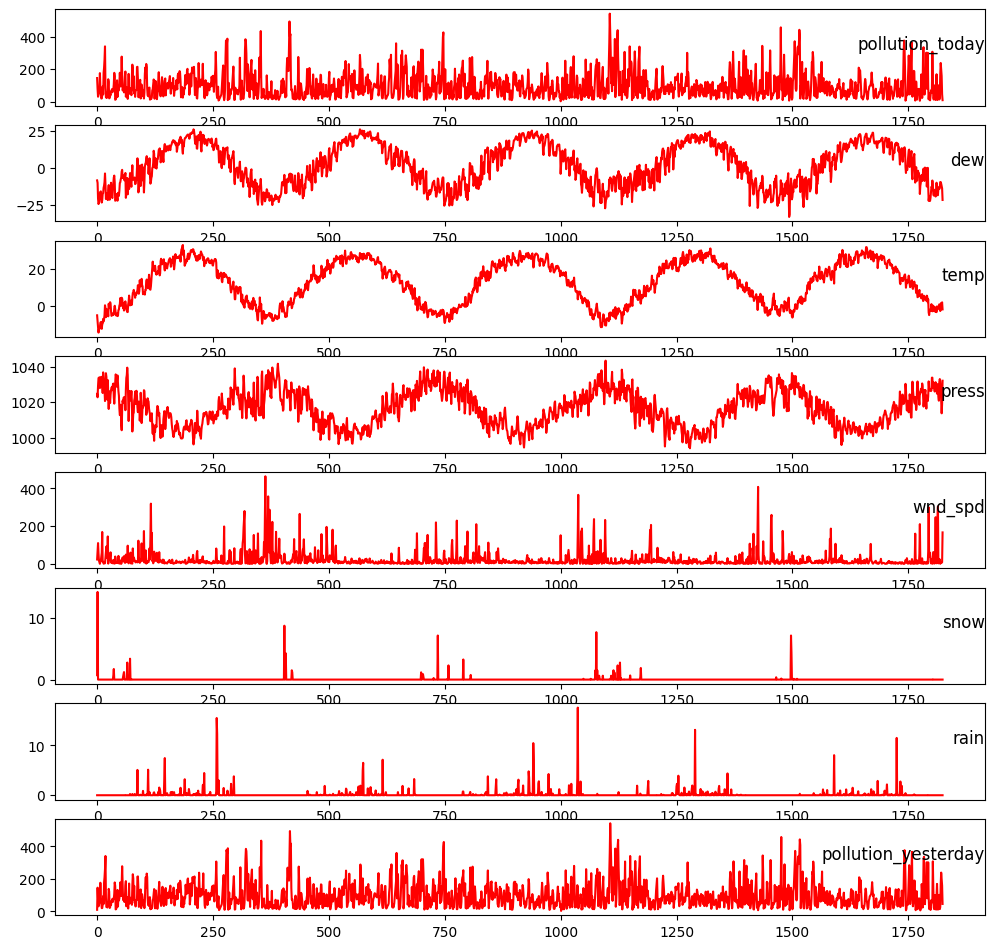

In [32]:
values = air_pollution.values
groups = [0, 1, 2, 3, 4, 5, 6, 7]
i = 1
# plot each column
fig, axes = plt.subplots(7, 2, dpi=100, figsize=(12, 12))
axes = axes.ravel()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group], color="red")
    plt.title(air_pollution.columns[group], y=0.5, loc='right')
    i += 1


plt.show()

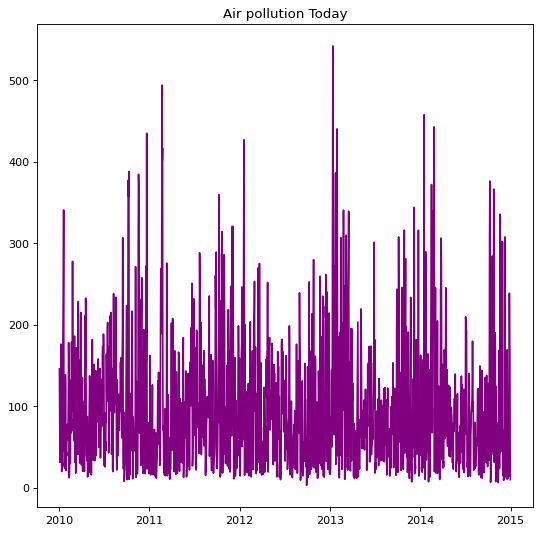

In [34]:
plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Air pollution Today', fontsize=12)

plt.plot(air_pollution.pollution_today, color="purple")

# **Trend**
A trend is observed when there is an increasing or decreasing slope observed in the time series. A trend is a smooth, general, long-term, average tendency. It is not always necessary that the increase or decrease is in the same direction throughout the given period of time.

Trend can be removed from your time series data (and data in the future) as a data preparation and cleaning exercise. This is common when using statistical methods for time series forecasting, but does not always improve results when using machine learning models. We will see different methods for this in the making your series stationary section.

Now we will try some methods to check for trend in our series:

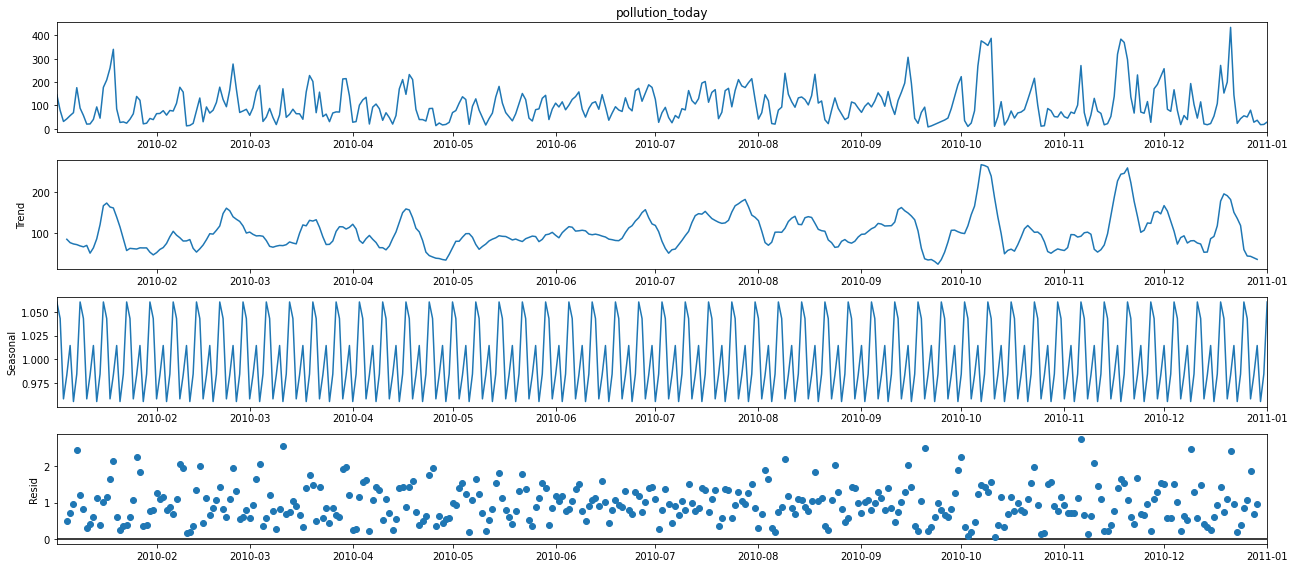

<Figure size 4000x1600 with 0 Axes>

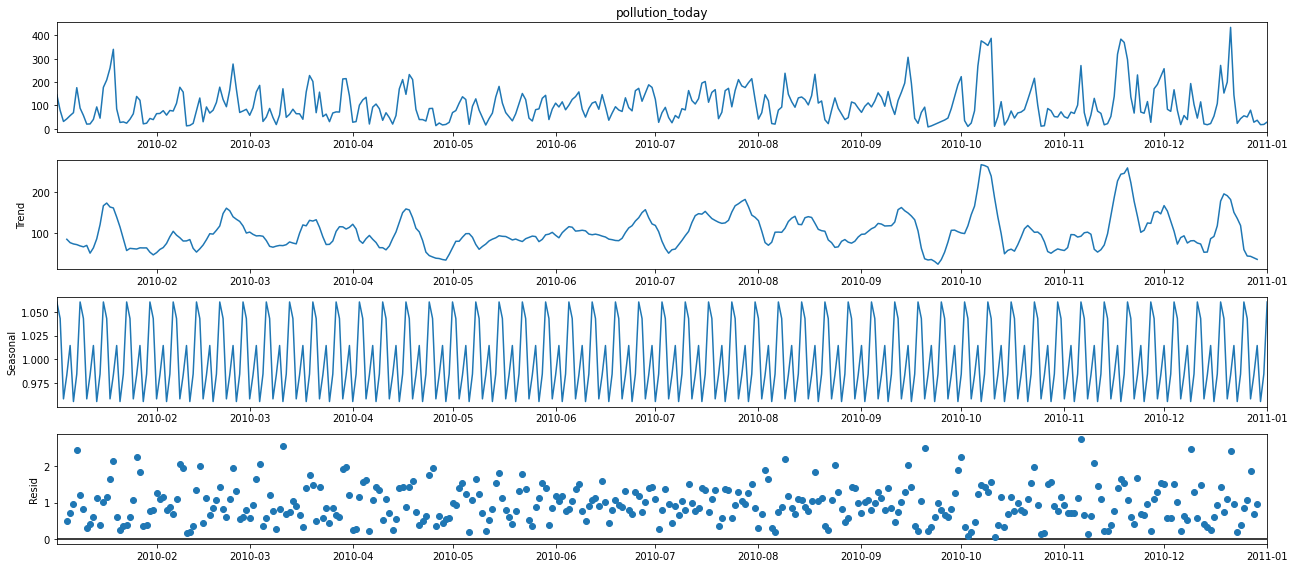

In [9]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = air_pollution.pollution_today[:365]
result = seasonal_decompose(series, model='multiplicative')
result.plot()

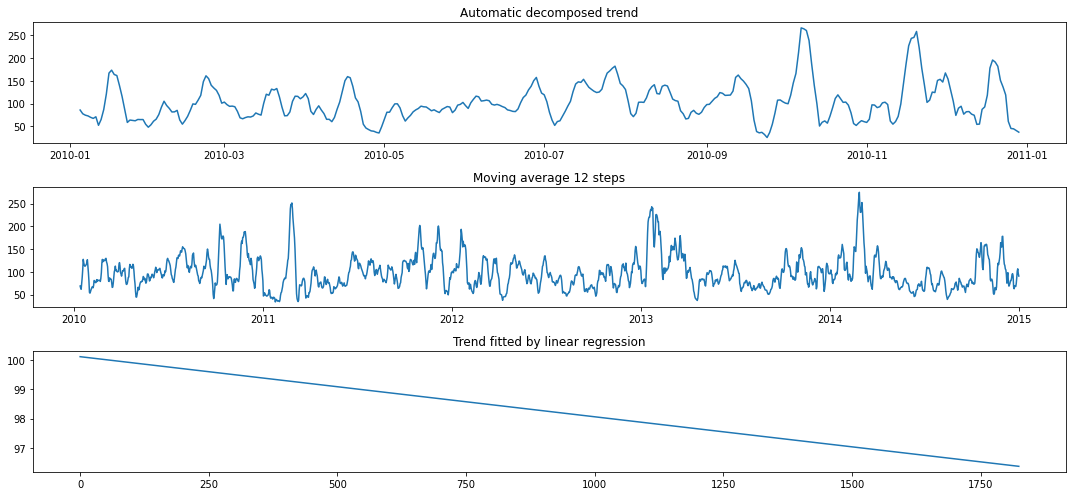

In [10]:
fig = plt.figure(figsize=(15, 7))
layout = (3, 2)
pm_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
mv_ax = plt.subplot2grid(layout, (1, 0), colspan=2)
fit_ax = plt.subplot2grid(layout, (2, 0), colspan=2)

pm_ax.plot(result.trend)
pm_ax.set_title("Automatic decomposed trend")

mm = air_pollution.pollution_today.rolling(12).mean()
mv_ax.plot(mm)
mv_ax.set_title("Moving average 12 steps")


X = [i for i in range(0, len(air_pollution.pollution_today))]
X = np.reshape(X, (len(X), 1))
y = air_pollution.pollution_today.values
model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
fit_ax.plot(trend)
fit_ax.set_title("Trend fitted by linear regression")

plt.tight_layout()

# **Seasonality**
Seasonality is observed when there is a distinct repeated pattern observed between regular intervals due to seasonal factors. It could be because of the month of the year, the day of the month, weekdays or even time of the day. For example the amount of sunscream protector (always low in winter and high in summer).

The automatic decomposing chart did not gave us a good look into the decomposed seasonality, let's try decomposing smaller parts of the time series first and test seasonalities we found into the others.

Lets go with the first year of data only now:

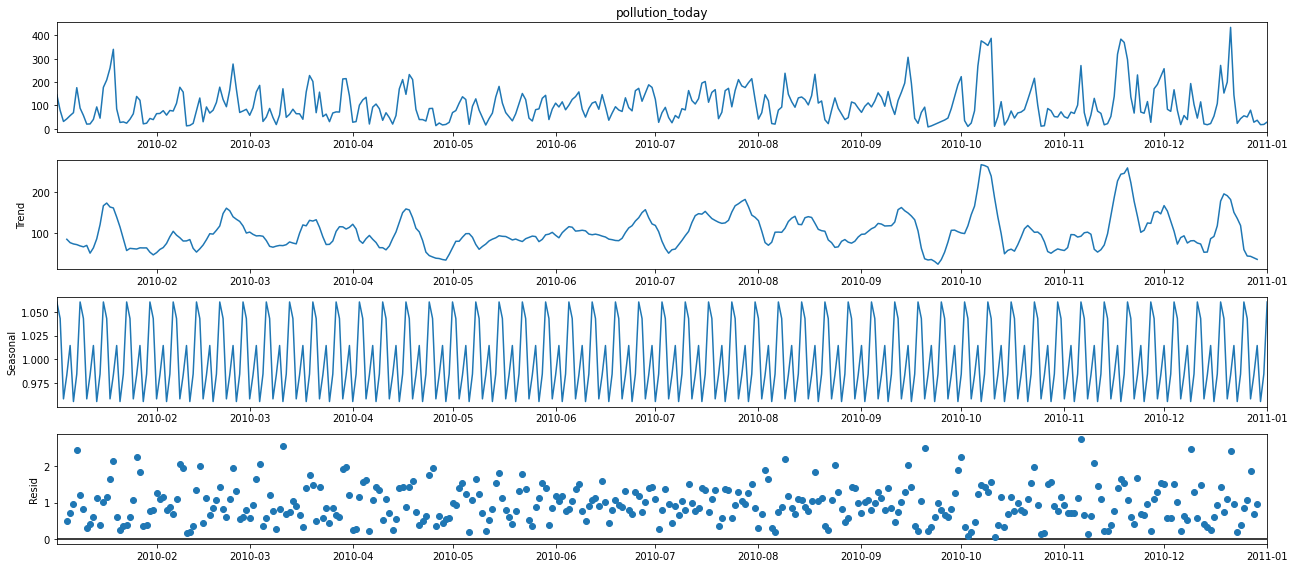

<Figure size 4000x1600 with 0 Axes>

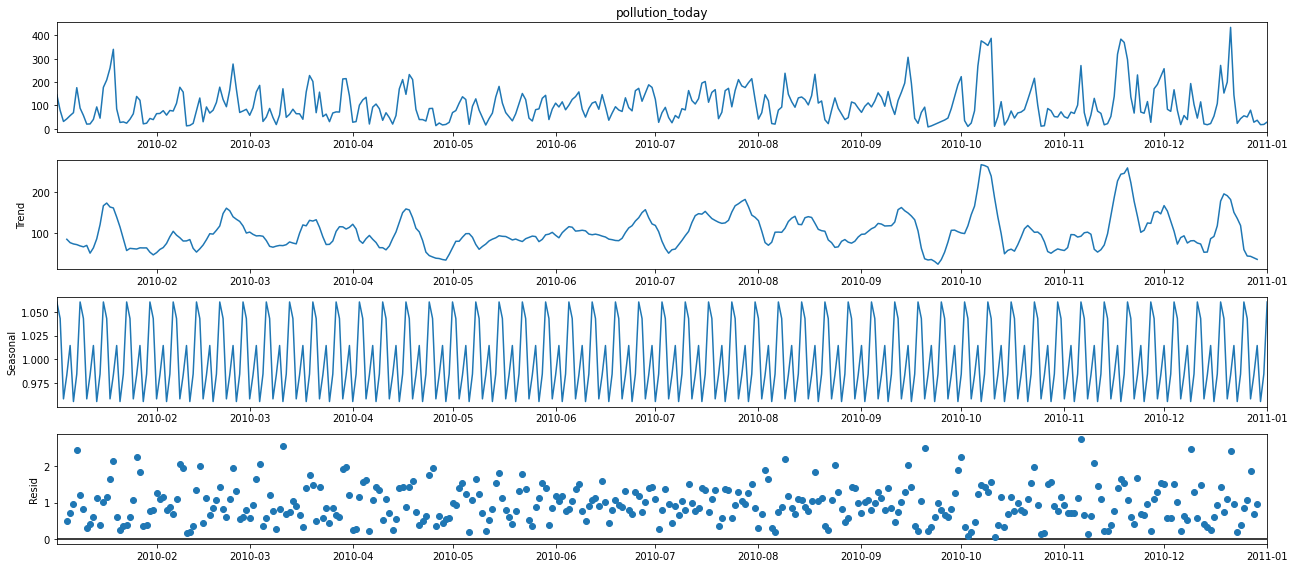

In [11]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = air_pollution.pollution_today[:365]
result = seasonal_decompose(series, model='multiplicative')
result.plot()

# **Stationary**
Stationarity is an important characteristic of time series. A time series is stationarity if it has constant mean and variance over time. Most models work only with stationary data as this makes it easier to model. Not all time series are stationary but we can transform them into stationary series in different ways.

Often, stock prices are not a stationary process, since we might see a growing trend, or its volatility might increase over time (meaning that variance is changing).

**Augmented Dickey-Fuller test**

The Augmented Dickey-Fuller test is a type of statistical test called a unit root test. The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend. There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure. Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure. We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary. p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary. Below is an example of calculating the Augmented Dickey-Fuller test on the Daily Female Births dataset. The statsmodels library provides the adfuller() function that implements the test.

In [12]:
X = air_pollution.pollution_today.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.116719
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


# **modeling: AR-ARIMA-MA**

In [35]:
def visualize_results(train, predictions, model_name):
    plt.figure(figsize=(16, 4), dpi=100)
    plt.plot(train, lw=1, label='original')
    plt.plot(predictions, color='orange', lw=1, label='prediction')
    plt.title(f'{model_name} Model')
    plt.legend()
    plt.xlabel = pd.date_range(start='1/1/2010', end='12/31/2014', freq='w')
    plt.show()

In [36]:
def calculate_loss(train, predictions, model_name, a, b) : 
    y_true = train[a:]
    y_pred = predictions[a:b]
    print(f'{model_name} Huber loss is : {huber(y_true, y_pred, delta=1.0)}') 

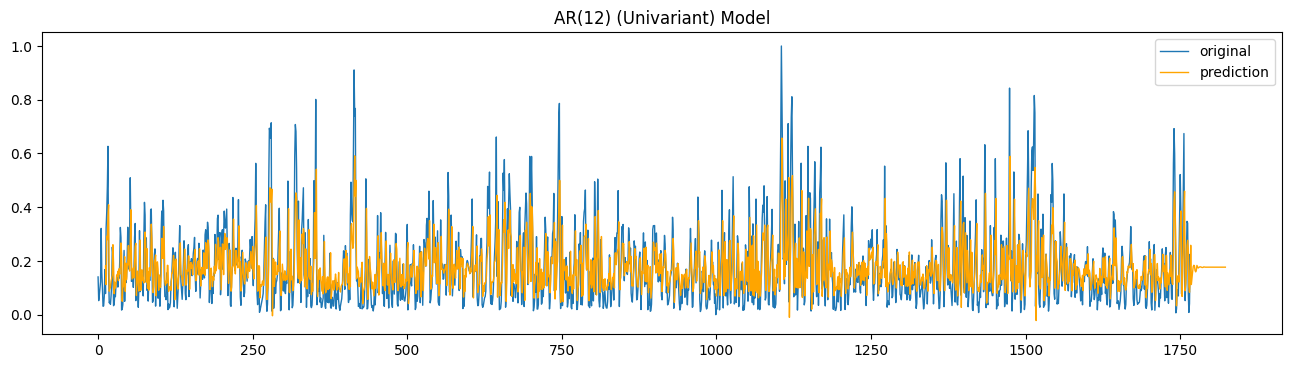

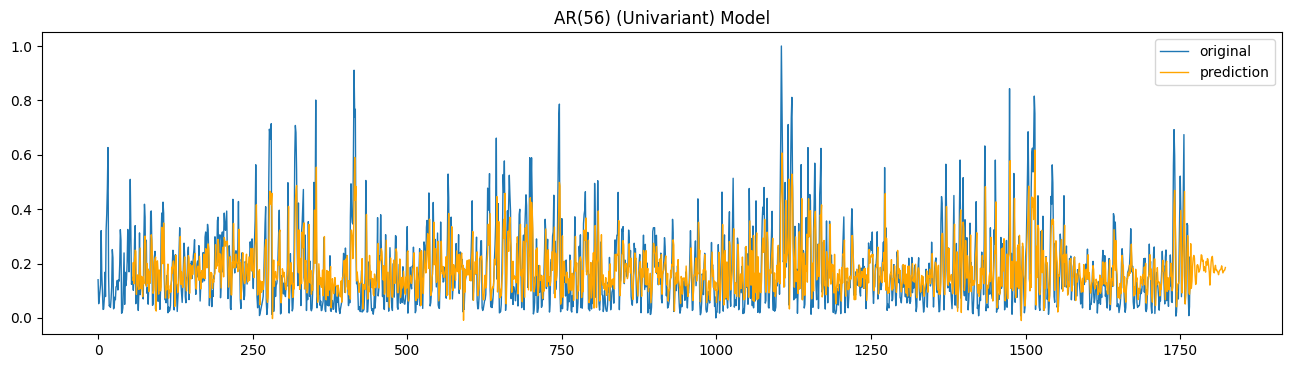

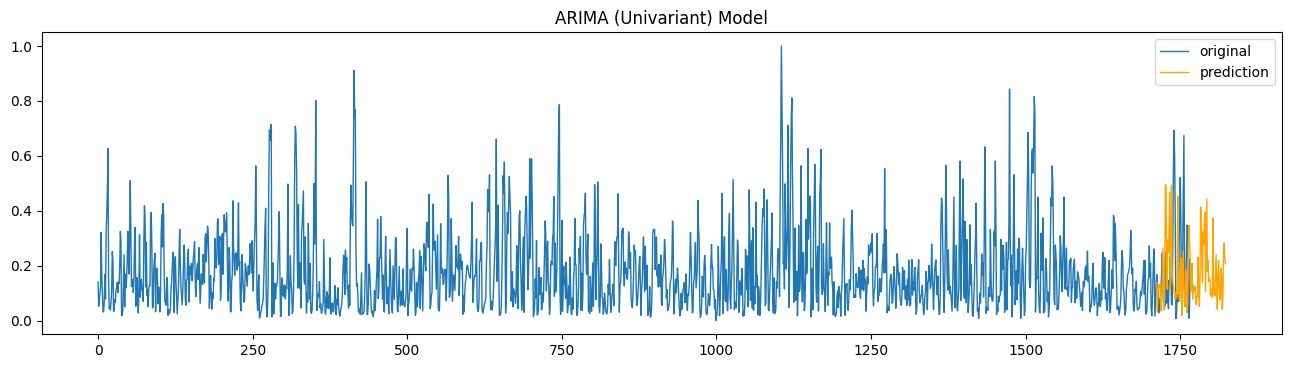

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: 

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

X = air_pollution.pollution_today.values
scaler = MinMaxScaler()
X = scaler.fit_transform(X.reshape(len(X), 1))
X = X.reshape(X.shape[0])
train, test = X[1:len(X)-56], X[len(X)-56:]



# AR
model = AutoReg(train, lags=12)
model_fit = model.fit()
predictions = model_fit.predict(start=0, end=len(train)+len(test)-1, dynamic=False)
visualize_results(train, predictions, 'AR(12) (Univariant)')



# AR
model = AutoReg(train, lags=56)
model_fit = model.fit()
predictions = model_fit.predict(start=0, end=len(train)+len(test)-1, dynamic=False)
visualize_results(train, predictions, 'AR(56) (Univariant)')


# ARIMA
predictions = [None for i in range(len(train) - len(test))]
history = [x for x in train]
test = [x for x in test]
for t in range(len(test)*2):
	model = ARIMA(history, order=(5, 1, 0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat); history.append(test[t]); test.append(yhat)
visualize_results(train, predictions, 'ARIMA (Univariant)')


# MA
predictions = [None for i in range(len(train) - len(test))]
history = [x for x in train]
test = [x for x in test]
for t in range(len(test)*2):
	model = ARIMA(history, order=(0, 0, 3))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat); history.append(test[t]); test.append(yhat)
visualize_results(train, predictions, 'MA (Univariant)')



# **Multivariant AR**

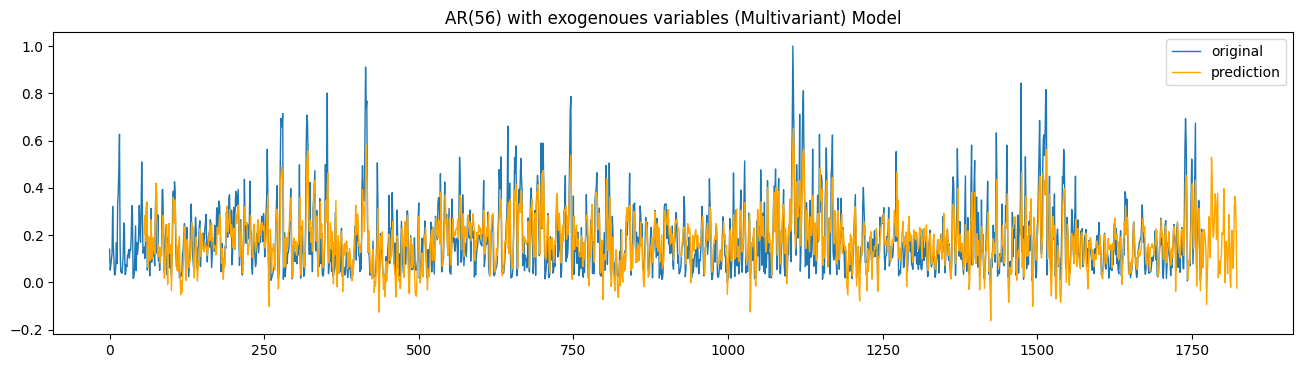

In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

X = air_pollution.pollution_today.values
scaler = MinMaxScaler()
X = scaler.fit_transform(X.reshape(len(X), 1))
X = X.reshape(X.shape[0])
train, test = X[1:len(X)-56], X[len(X)-56:]
train2 = air_pollution.values[1:len(X)-56, 1:]
test2 = air_pollution.values[len(X)-56:, 1:]


model = AutoReg(train, exog=train2, lags=56)
model_fit = model.fit()
predictions = model_fit.predict(start=0, end=len(train)+len(test)-1, dynamic=False, exog_oos=test2)
visualize_results(train, predictions, 'AR(56) with exogenoues variables (Multivariant)')

# **LSTM**

In [31]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
cols = air_pollution.columns
idx = air_pollution.index
new_df = pd.DataFrame(scaler.fit_transform(air_pollution), columns=cols)
new_df.index = idx



from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model = Sequential()
model.add(layers.Embedding(input_dim=56, output_dim=56))
model.add(layers.LSTM(56, activation='linear', return_sequences=False))
model.add(layers.Dense(56, activation='linear'))
model.add(layers.Dense(56))

model.compile(loss='huber', optimizer='adagrad')



for epoch in range(0, len(air_pollution)- 56*2 - 1, 1) : 
    #print(f'epoch: {epoch}')
    x = new_df.pollution_today[epoch:56+epoch].values
    y = new_df.pollution_today[56+epoch:2*56+epoch].values
    model.fit(x, y, shuffle=False, verbose=0, batch_size=1)


pred = model.predict(new_df.pollution_today[len(air_pollution)-56:len(air_pollution)].values)[0]
pred = pd.Series(pred)
pred.index = pd.date_range(start='12/29/2014', end='1/29/2016', freq='w')

visualize_results(new_df.pollution_today, pred, 'LSTM (Huber Loss & Adagrad Optimizer & Linear Activations)')

ValueError: ignored